In [2]:
from maps.screens import ImageScreenMultiAntibody
from maps.multiantibody.config import TrainConfig, ModelConfig, DataLoaderConfig
import json
import importlib
import pandas as pd

import sys
sys.path.append("/home/kkumbier/maps/")
import maps.multiantibody.data_loaders as data_loaders
import maps.multiantibody.models as models
import maps.multiantibody.training as training
import maps.multiantibody.evaluate as evaluate

# --- Initialize parameters ---
pdir = "/home/kkumbier/als/scripts/maps/template_analyses/params/"
with open(pdir + "binary-split-train.json", "r") as f:
    train_params = json.load(f)

with open(pdir + "binary-split-test.json", "r") as f:
    test_params = json.load(f)

dataloader_config = DataLoaderConfig()
train_config = TrainConfig()
model_config = ModelConfig()
model_config.n_classes = 2

antibodies = ["HSP70/SOD1", "FUS/EEA1"]
response_map = {0: "WT", 1: "FUS"}

In [3]:
# Load and process screens for train / test
train_screen = ImageScreenMultiAntibody(train_params)
#antibodies = train_screen.loader.list_antibodies().to_list()
train_screen.load(antibody=antibodies)

test_screen = ImageScreenMultiAntibody(test_params)
test_screen.load(antibody=antibodies)

print("Processing training set...")
train_screen.preprocess()

print("Processing test set...")
test_screen.preprocess()

for ab in  antibodies:
    print(f"Marker set: {ab}")
    print(f"Train data: {train_screen.data[ab].shape}")
    print(f"Test data: {test_screen.data[ab].shape}")

Processing training set...
Processing test set...
Marker set: HSP70/SOD1
Train data: (24466, 311)
Test data: (22471, 311)
Marker set: FUS/EEA1
Train data: (24907, 315)
Test data: (22915, 315)


In [4]:
importlib.reload(data_loaders)
create_multiantibody_dataloader = data_loaders.create_multiantibody_dataloader

dataloader_config = DataLoaderConfig()
dataloader_config.batch_size = 8
dataloader_config.response_map = {"Muatations": response_map}

train_dataloader = create_multiantibody_dataloader(
    train_screen,
    **vars(dataloader_config)
)

#dataloader_config.mode = "eval"
#dataloader_config.n_cells = 250
test_dataloader = create_multiantibody_dataloader(
    test_screen,
    scalers=train_dataloader._get_scalers(),
    **vars(dataloader_config)
)

In [5]:
importlib.reload(training)
importlib.reload(models)
importlib.reload(evaluate)

eval_model = evaluate.eval
train = training.train
MultiAntibodyClassifier = models.MultiAntibodyClassifier

# Initiaize model and train
train_config.n_epochs = 100
train_config.patience = 10
train_config.lr = 5e-3
train_config.use_contrastive_loss = True

model_config.antibody_feature_dims = train_dataloader._get_feature_dims()
model_config.d_model = 16
model_config.n_layers = 1

model_train = MultiAntibodyClassifier(**vars(model_config))
train(model_train, train_dataloader, train_config)

print("Evaluating model...")
test_dataloader.mode = "eval"
df_test, emb_test = eval_model(model_train, test_dataloader)

model_test = MultiAntibodyClassifier(**vars(model_config))
test_dataloader.mode = "train"
train(model_test, test_dataloader, train_config)

print("Evaluating model...")
train_dataloader.mode = "eval"
df_train, emb_train = eval_model(model_test, train_dataloader)

Starting cell-level training...
Cell Epoch 1/100, Overall Loss: 2.9463, Active: 2/2
  FUS/EEA1 - Loss: 0.7270, Acc: 0.5050 
  HSP70/SOD1 - Loss: 0.7854, Acc: 0.4950 
Cell Epoch 1/100, Overall Loss: 2.9463, Active: 2/2
  FUS/EEA1 - Loss: 0.7270, Acc: 0.5050 
  HSP70/SOD1 - Loss: 0.7854, Acc: 0.4950 
Cell Epoch 2/100, Overall Loss: 2.7948, Active: 2/2
  FUS/EEA1 - Loss: 0.7031, Acc: 0.5475 
  HSP70/SOD1 - Loss: 0.7273, Acc: 0.5037 
Cell Epoch 2/100, Overall Loss: 2.7948, Active: 2/2
  FUS/EEA1 - Loss: 0.7031, Acc: 0.5475 
  HSP70/SOD1 - Loss: 0.7273, Acc: 0.5037 
Cell Epoch 3/100, Overall Loss: 2.7614, Active: 2/2
  FUS/EEA1 - Loss: 0.6981, Acc: 0.5375 
  HSP70/SOD1 - Loss: 0.7565, Acc: 0.4862 
Cell Epoch 3/100, Overall Loss: 2.7614, Active: 2/2
  FUS/EEA1 - Loss: 0.6981, Acc: 0.5375 
  HSP70/SOD1 - Loss: 0.7565, Acc: 0.4862 
Cell Epoch 4/100, Overall Loss: 2.6550, Active: 2/2
  FUS/EEA1 - Loss: 0.6819, Acc: 0.5837 
  HSP70/SOD1 - Loss: 0.7254, Acc: 0.5000 
Cell Epoch 4/100, Overall Loss

/awlab/projects/2024_ALS/software/miniforge3/envs/maps/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Cell Epoch 17/100, Overall Loss: 2.3771, Active: 1/2
  FUS/EEA1 - Loss: 0.5689, Acc: 0.7225 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 18/100, Overall Loss: 2.3247, Active: 1/2
  FUS/EEA1 - Loss: 0.5706, Acc: 0.6900 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 18/100, Overall Loss: 2.3247, Active: 1/2
  FUS/EEA1 - Loss: 0.5706, Acc: 0.6900 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 19/100, Overall Loss: 2.3650, Active: 1/2
  FUS/EEA1 - Loss: 0.5975, Acc: 0.6800 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 19/100, Overall Loss: 2.3650, Active: 1/2
  FUS/EEA1 - Loss: 0.5975, Acc: 0.6800 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 20/100, Overall Loss: 2.2987, Active: 1/2
  FUS/EEA1 - Loss: 0.5867, Acc: 0.6875 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 20/100, Overall Loss: 2.2987, Active: 1/2
  FUS/EEA1 - Loss: 0.5867, Acc: 0.6875 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]

/awlab/projects/2024_ALS/software/miniforge3/envs/maps/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Cell Epoch 31/100, Overall Loss: 2.1284, Active: 1/2
  FUS/EEA1 - Loss: 0.6090, Acc: 0.6612 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 32/100, Overall Loss: 2.1026, Active: 1/2
  FUS/EEA1 - Loss: 0.5664, Acc: 0.7000 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 32/100, Overall Loss: 2.1026, Active: 1/2
  FUS/EEA1 - Loss: 0.5664, Acc: 0.7000 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 33/100, Overall Loss: 2.2728, Active: 1/2
  FUS/EEA1 - Loss: 0.7134, Acc: 0.5775 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 33/100, Overall Loss: 2.2728, Active: 1/2
  FUS/EEA1 - Loss: 0.7134, Acc: 0.5775 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 34/100, Overall Loss: 2.0299, Active: 1/2
  FUS/EEA1 - Loss: 0.5427, Acc: 0.7375 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 34/100, Overall Loss: 2.0299, Active: 1/2
  FUS/EEA1 - Loss: 0.5427, Acc: 0.7375 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]

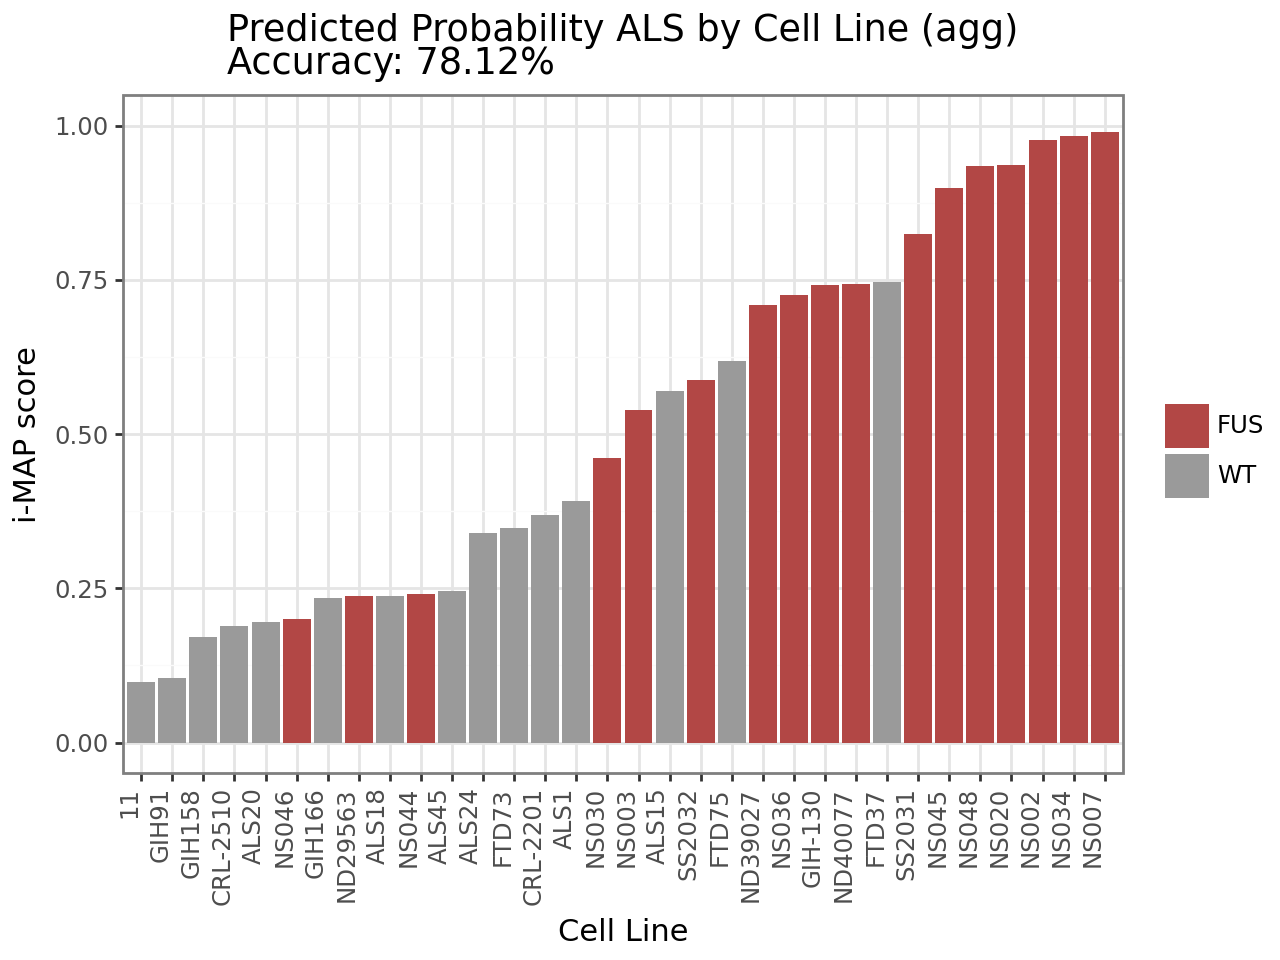

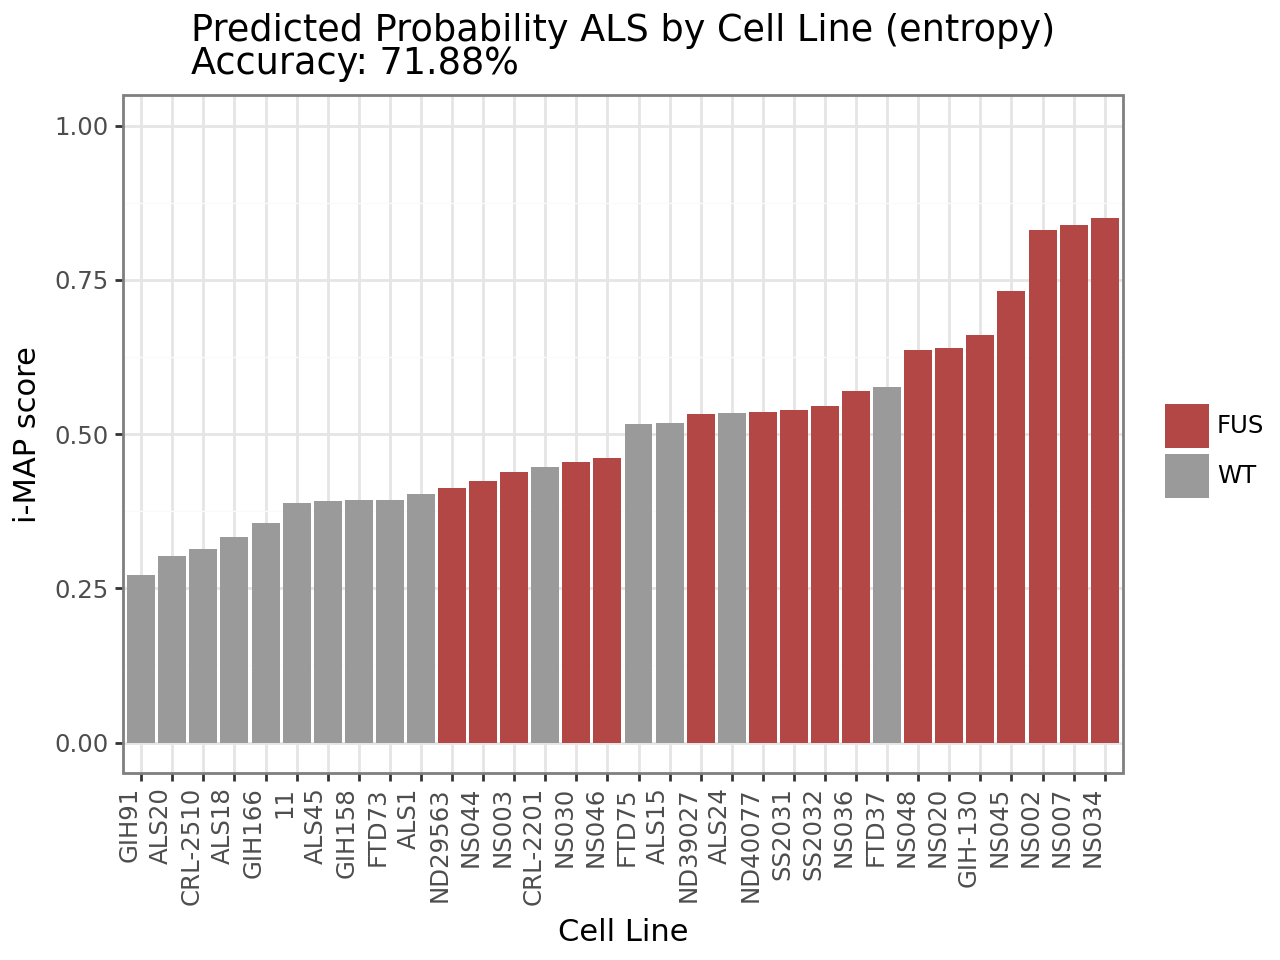

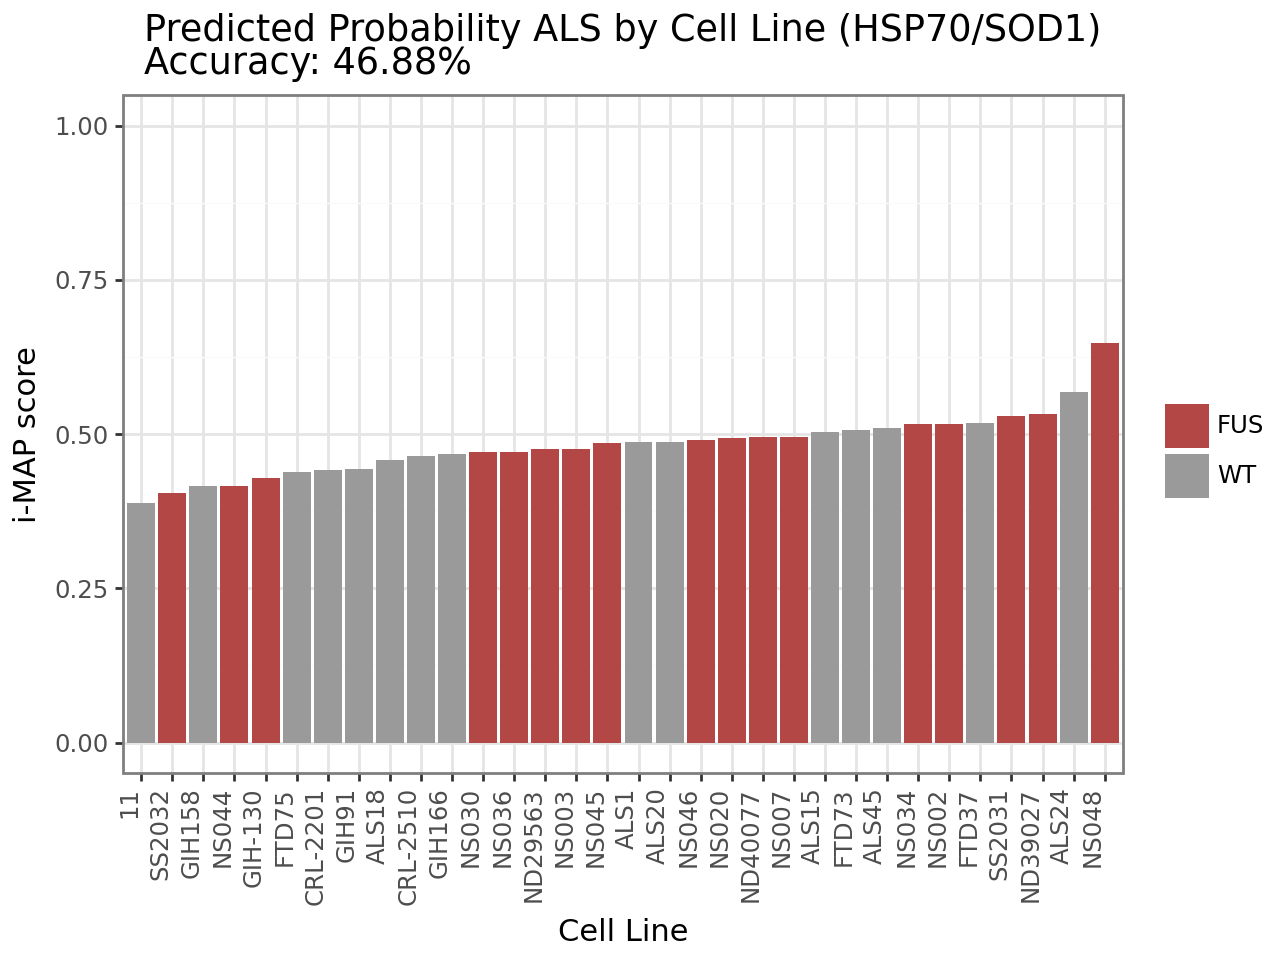

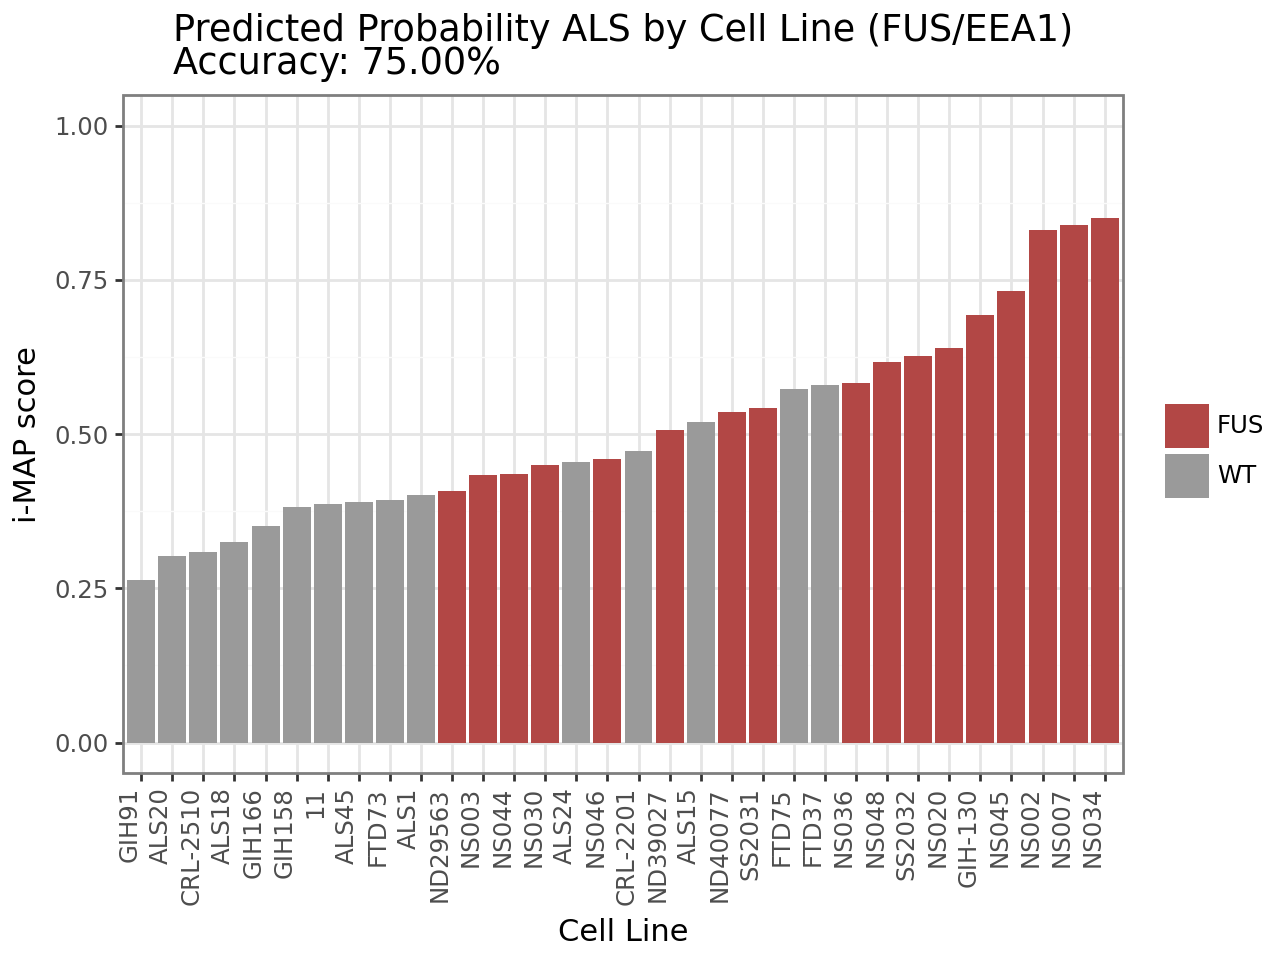

In [6]:
from IPython.display import display
from maps.figures import PALETTE

from plotnine import (
    ggplot, aes, geom_bar, theme, element_text, labs, ggtitle, scale_fill_manual, ylim, theme_bw
)

df = pd.concat([df_train, df_test])
groups = ["agg", "entropy"] + antibodies

def plot_preds(df, groups, response_map):
    for g in groups:
        # Sort preds by predicted probability (Class_1) in ascending order
        preds = df.sort_values(by=f'class_1_{g}', ascending=True)
        preds["True"] = preds["True"].map(response_map)
        
        preds['CellLines'] = pd.Categorical(
            preds['CellLines'], categories=preds['CellLines'], ordered=True
        )
        
        # Compute prediction accuracy for current group
        pred_labels = (preds[f'class_1_{g}'] > 0.5).map({True: "FUS", False: "WT"})
        accuracy = (pred_labels == preds["True"]).mean()
        
        p = (
            ggplot(preds, aes(x='CellLines', y=f'class_1_{g}', fill='True')) +
            geom_bar(stat='identity') +
            theme_bw() +
            theme(axis_text_x=element_text(rotation=90, hjust=1)) +
            labs(x='Cell Line', y='i-MAP score', fill="") +
            ggtitle(
                f"Predicted Probability ALS by Cell Line ({g})\nAccuracy: {accuracy:.2%}") +
            scale_fill_manual(values=PALETTE) +
            ylim(0, 1)
        )
        display(p)
        
plot_preds(df, groups, response_map)

In [24]:
import torch
from sklearn.preprocessing import StandardScaler

# Scale train and test embeddings independently before merging
emb_train_scaled = emb_train["FUS/EEA1"].view(-1, model_config.d_model).cpu().numpy()
emb_test_scaled = emb_test["FUS/EEA1"].view(-1, model_config.d_model).cpu().numpy()

# Scale independently
scaler_train = StandardScaler()
emb_train_scaled = scaler_train.fit_transform(emb_train_scaled)

scaler_test = StandardScaler()
emb_test_scaled = scaler_test.fit_transform(emb_test_scaled)

# Reshape back to original tensor structure
train_shape = emb_train["FUS/EEA1"].shape
test_shape = emb_test["FUS/EEA1"].shape

emb_train_scaled = torch.from_numpy(emb_train_scaled).view(train_shape)
emb_test_scaled = torch.from_numpy(emb_test_scaled).view(test_shape)

# Merge the scaled embeddings
emb = torch.cat([emb_train_scaled, emb_test_scaled], dim=0)
embeddings = {"FUS/EEA1": emb}


Processing antibody: FUS/EEA1


/awlab/projects/2024_ALS/software/miniforge3/envs/maps/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


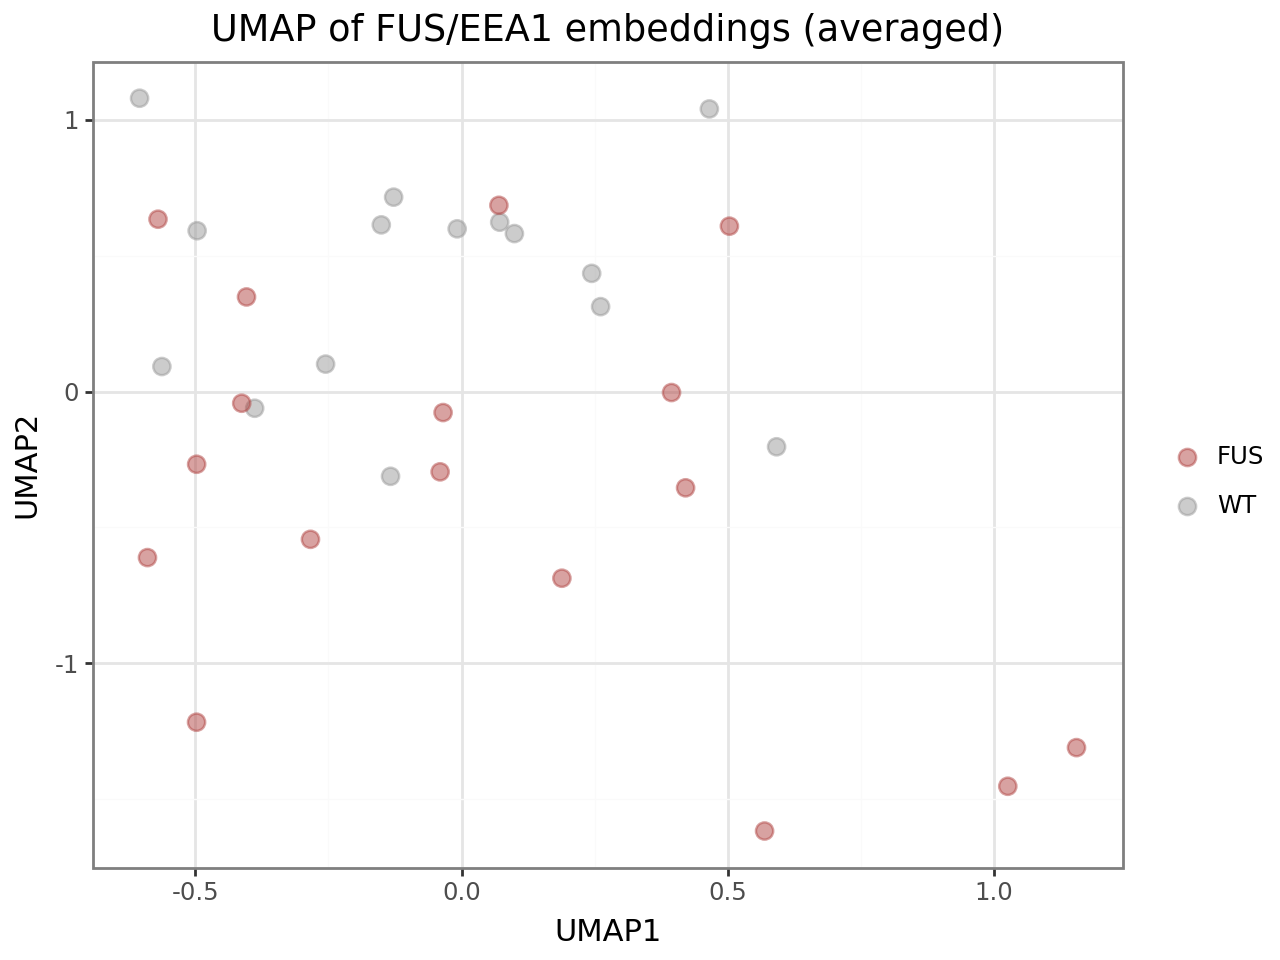

In [25]:
from plotnine import geom_point, scale_color_manual, stat_density_2d
from sklearn.preprocessing import StandardScaler
import umap
import numpy as np

label_key = {0: "WT", 1: "FUS"}
labels = df["True"].map(label_key).values

# Create train/test indicators
n_train_samples = len(df_train)
n_test_samples = len(df_test)
train_test_indicator = ['train'] * n_train_samples + ['test'] * n_test_samples

# Prepare DataFrame for individual antibody UMAPs
for i, (ab, emb) in enumerate(embeddings.items()):
    print(f"\nProcessing antibody: {ab}")
    reducer = umap.UMAP(random_state=42, n_neighbors=25)
    original_shape = emb.shape
    emb_numpy = emb.view(-1, model_config.d_model).cpu().numpy()
    
    # Note: embeddings are already scaled independently in previous cell
    # Apply UMAP transformation
    emb_2d = reducer.fit_transform(emb_numpy)
    
    # Separate train and test UMAP embeddings
    n_cells_per_line = original_shape[1]
    train_cells = n_train_samples * n_cells_per_line
    test_cells = n_test_samples * n_cells_per_line
    
    emb_2d_train = emb_2d[:train_cells]
    emb_2d_test = emb_2d[train_cells:]
    
    # Scale UMAP embeddings separately for train and test
    scaler_umap_train = StandardScaler()
    emb_2d_train_scaled = scaler_umap_train.fit_transform(emb_2d_train)
    
    scaler_umap_test = StandardScaler()
    emb_2d_test_scaled = scaler_umap_test.fit_transform(emb_2d_test)
    
    # Combine scaled UMAP embeddings
    emb_2d_scaled = np.vstack([emb_2d_train_scaled, emb_2d_test_scaled])
    
    # Create labels with train/test indicator
    labels_ = np.repeat(labels, n_cells_per_line)
    train_test_labels = np.repeat(train_test_indicator, n_cells_per_line)
    
    # Reshape for averaging
    emb_shape = original_shape
    emb_2d_avg = emb_2d_scaled.reshape(emb_shape[0], emb_shape[1], -1).mean(axis=1)

    df_umap_avg = pd.DataFrame({
        "UMAP1": emb_2d_avg[:, 0],
        "UMAP2": emb_2d_avg[:, 1],
        "Label": labels,
        "Split": train_test_indicator
    })
    
    # Scatter plot
    p = (
        ggplot(df_umap_avg, aes(x="UMAP1", y="UMAP2", color="Label")) +
        geom_point(size=3, alpha=0.5) +
        scale_color_manual(values=PALETTE) +
        labs(color="") +
        ggtitle(f"UMAP of {ab} embeddings (averaged)") +
        theme_bw()
    )
    display(p)
   
    df_umap = pd.DataFrame({
        "UMAP1": emb_2d_scaled[:, 0],
        "UMAP2": emb_2d_scaled[:, 1],
        "Label": labels_,
        "Split": train_test_labels
    })

UMAP embeddings without decision boundaries:


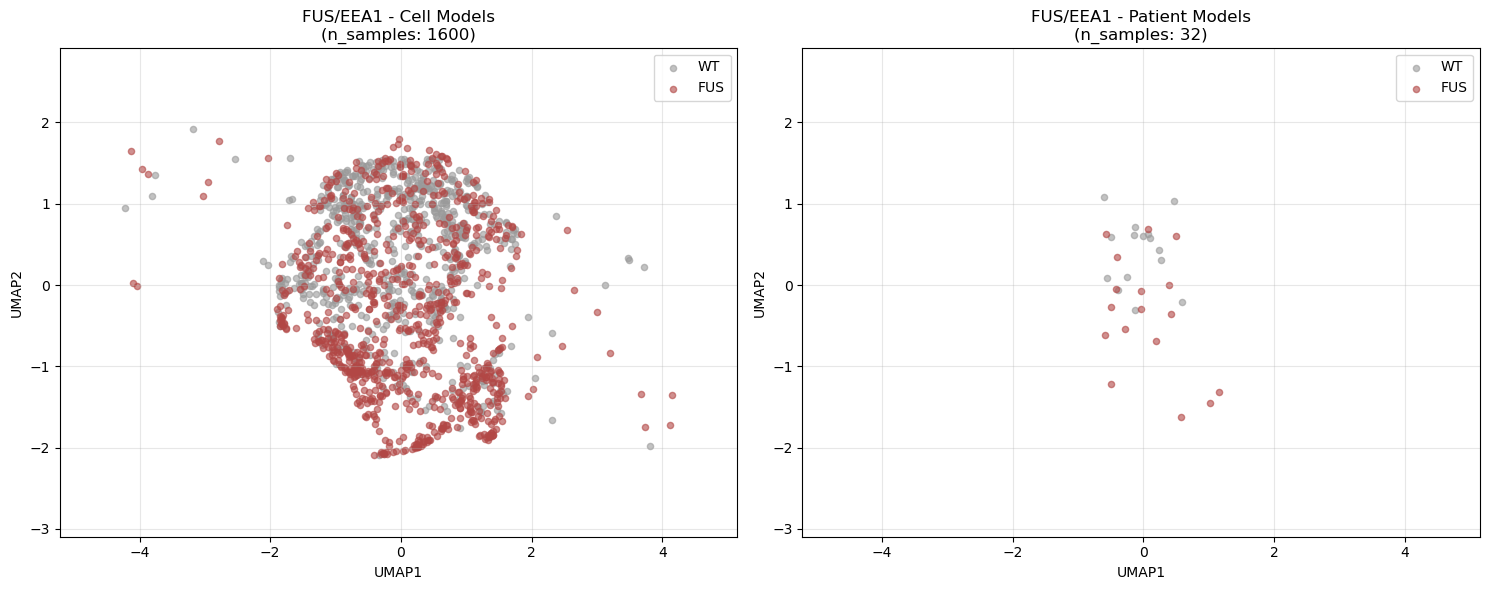


UMAP embeddings with bootstrap decision boundaries:


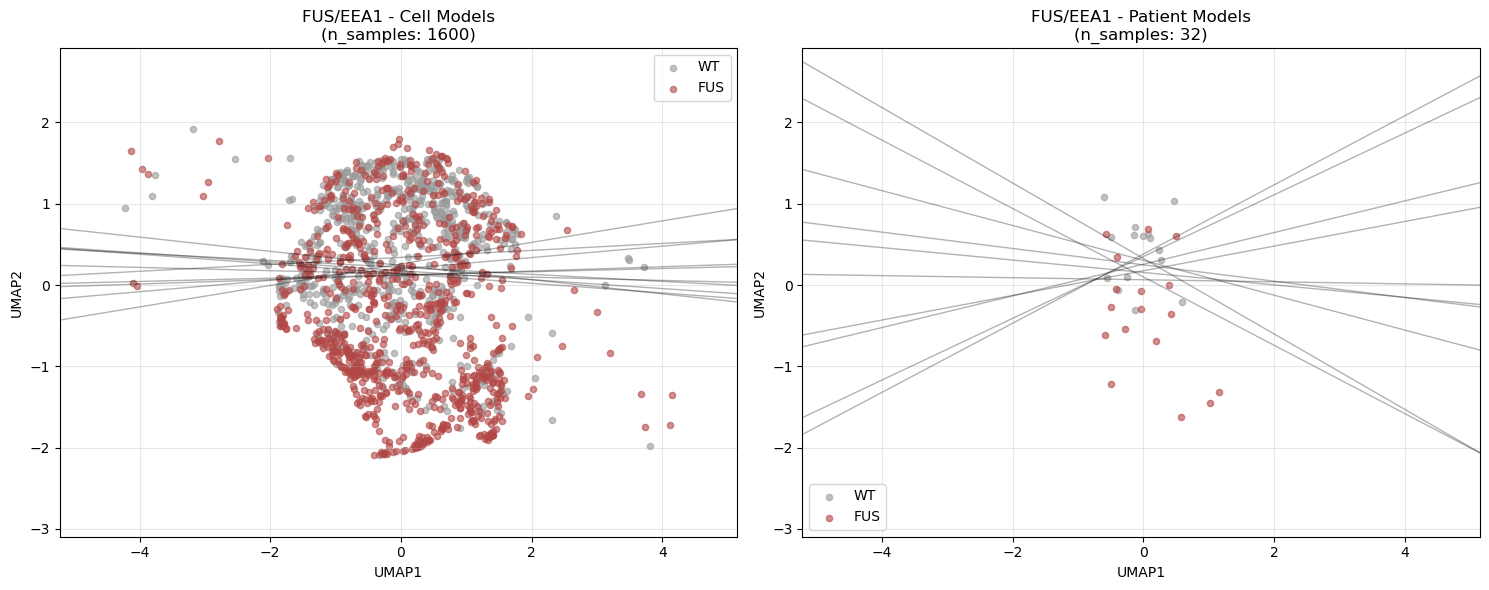

In [30]:
# Bootstrap logistic regression experiment
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import matplotlib.pyplot as plt

def bootstrap_logistic_experiment(df_concat, df_avg, ab_name, n_bootstrap=10):
    """
    Compare concatenate vs average embeddings with bootstrap logistic regression.
    """
    results = {'concatenate': {}, 'average': {}}
    
    # Prepare data for both settings
    datasets = {
        'concatenate': df_concat,
        'average': df_avg
    }
    
    for setting_name, data in datasets.items():
        X = data[['UMAP1', 'UMAP2']].values
        y = (data['Label'] == 'FUS').astype(int).values  # Convert to binary
        
        coefficients = []
        intercepts = []
        
        # Bootstrap sampling and fitting
        for i in range(n_bootstrap):
            # Bootstrap sample
            X_boot, y_boot = resample(X, y, random_state=i)
            
            # Fit logistic regression
            lr = LogisticRegression(random_state=i)
            lr.fit(X_boot, y_boot)
            
            coefficients.append(lr.coef_[0])
            intercepts.append(lr.intercept_[0])
        
        results[setting_name] = {
            'X': X,
            'y': y,
            'coefficients': coefficients,
            'intercepts': intercepts
        }
    
    return results

def plot_decision_boundaries(results, ab_name, show_boundaries=True):
    """Plot embeddings with optional decision boundaries from bootstrap samples."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Calculate global axis limits across both settings
    all_X = []
    for setting in ['concatenate', 'average']:
        all_X.append(results[setting]['X'])
    combined_X = np.vstack(all_X)
    
    x_min_global = combined_X[:, 0].min() - 1
    x_max_global = combined_X[:, 0].max() + 1
    y_min_global = combined_X[:, 1].min() - 1
    y_max_global = combined_X[:, 1].max() + 1
    
    for idx, setting in enumerate(['concatenate', 'average']):
        ax = axes[idx]
        
        # Get data
        X = results[setting]['X']
        y = results[setting]['y']
        coefficients = results[setting]['coefficients']
        intercepts = results[setting]['intercepts']
        
        # Plot points colored by class using PALETTE
        from maps.figures import PALETTE
        colors = [PALETTE['WT'], PALETTE['FUS']]  # Use PALETTE colors
        labels = ['WT', 'FUS']
        
        for class_val in [0, 1]:
            mask = y == class_val
            ax.scatter(X[mask, 0], X[mask, 1], 
                      c=colors[class_val], label=labels[class_val], 
                      alpha=0.6, s=20)
        
        # Plot decision boundaries (separating hyperplane) only if requested
        if show_boundaries:
            for coef, intercept in zip(coefficients, intercepts):
                # Decision boundary: w0*x + w1*y + b = 0
                # This is the actual separating hyperplane where P(y=1) = 0.5
                w0, w1 = coef[0], coef[1]
                b = intercept
                
                if abs(w1) > 1e-6:  # Non-vertical line
                    xx = np.linspace(x_min_global, x_max_global, 100)
                    yy = -(w0 * xx + b) / w1
                    ax.plot(xx, yy, 'k-', alpha=0.3, linewidth=1)
                elif abs(w0) > 1e-6:  # Vertical line
                    x_boundary = -b / w0
                    if x_min_global <= x_boundary <= x_max_global:
                        ax.axvline(x=x_boundary, color='k', alpha=0.3, linewidth=1)
        
        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')
        if setting == 'concatenate':
            ax.set_title(f'{ab_name} - Cell Models\n(n_samples: {len(X)})')
        else:  # average
            ax.set_title(f'{ab_name} - Patient Models\n(n_samples: {len(X)})')
        ax.legend()
        ax.grid(True, alpha=0.3)
        # Use global limits for both subplots
        ax.set_xlim(x_min_global, x_max_global)
        ax.set_ylim(y_min_global, y_max_global)
    
    plt.tight_layout()
    plt.show()

# Run the experiment for this antibody
results = bootstrap_logistic_experiment(
    df_umap, df_umap_avg, ab, n_bootstrap=10
)

# Plot without decision boundaries
print("UMAP embeddings without decision boundaries:")
plot_decision_boundaries(results, ab, show_boundaries=False)

# Plot with decision boundaries
print("\nUMAP embeddings with bootstrap decision boundaries:")
plot_decision_boundaries(results, ab, show_boundaries=True)